In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar


In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape


(11, 308153)

In [4]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Sum ColorSlope visitExposureTime > 19 HealpixSlicer': 'color slope',
            "Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer": "2day\ncolor slope",
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad',
            'Value At H=18.0 FractionPop Lightcurve Inversion MBA MoObjSlicer':'MBA LC Invert'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
         'color slope': 'N',
         '2day\ncolor slope': 'N',
         'MBA LC Invert': 'fraction',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [5]:
mag_data

,g,i,r,u,y,z
start_date_off_0_v4.0_10yrs,26.774161,26.369727,26.880749,25.550949,24.755955,25.709215
start_date_off_10_v4.0_10yrs,26.776461,26.360702,26.878406,25.563784,24.742477,25.708697
start_date_off_1_v4.0_10yrs,26.769014,26.366282,26.878439,25.556830,24.748389,25.718850
start_date_off_2_v4.0_10yrs,26.777374,26.361779,26.872292,25.551742,24.747372,25.714511
start_date_off_3_v4.0_10yrs,26.773095,26.373363,26.877582,25.552284,24.746178,25.716870
start_date_off_4_v4.0_10yrs,26.756985,26.368720,26.872411,25.563629,24.750967,25.714257
start_date_off_5_v4.0_10yrs,26.774698,26.365620,26.877786,25.563770,24.752203,25.721500
start_date_off_6_v4.0_10yrs,26.769218,26.366973,26.874100,25.558822,24.750574,25.716671
start_date_off_7_v4.0_10yrs,26.766633,26.368874,26.873761,25.547270,24.749862,25.715250
start_date_off_8_v4.0_10yrs,26.774742,26.364796,26.872894,25.557499,24.750119,25.714698


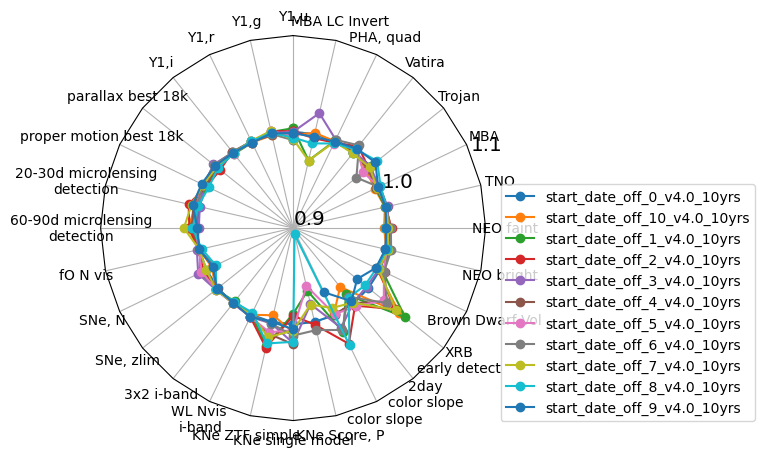

In [6]:
runs = [run for run in data.index if '4.0' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='start_date_off_0_v4.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.7, 0))


So here I've varied the start date of the survey by up to 10 days.

The weather is the same

The downtime is the same. The unscheduled downtime might align differently with the clouds, but the net effect should be very very small



In [7]:
# Note the MBA have 5k objects, so 0.14 fraction means N=700. Run the experiment again, expect N=700 /pm 26.
# So expect 1-sigma variation of 3.7% in metric value run-to-run, EVEN WITH THE EXACT SAME STRATEGY
data['MBA LC Invert']

start_date_off_0_v4.0_10yrs     0.142629
start_date_off_10_v4.0_10yrs    0.142829
start_date_off_1_v4.0_10yrs     0.138628
start_date_off_2_v4.0_10yrs     0.142028
start_date_off_3_v4.0_10yrs     0.145829
start_date_off_4_v4.0_10yrs          NaN
start_date_off_5_v4.0_10yrs          NaN
start_date_off_6_v4.0_10yrs          NaN
start_date_off_7_v4.0_10yrs     0.138628
start_date_off_8_v4.0_10yrs     0.141228
start_date_off_9_v4.0_10yrs     0.142228
Name: MBA LC Invert, dtype: float64

In [8]:
data_loaded['Identity Slew Count All visits UniSlicer']

start_date_off_0_v4.0_10yrs     2038634.0
start_date_off_10_v4.0_10yrs    2035946.0
start_date_off_1_v4.0_10yrs     2035916.0
start_date_off_2_v4.0_10yrs     2041202.0
start_date_off_3_v4.0_10yrs     2042614.0
start_date_off_4_v4.0_10yrs     2038189.0
start_date_off_5_v4.0_10yrs     2038076.0
start_date_off_6_v4.0_10yrs     2038313.0
start_date_off_7_v4.0_10yrs     2038579.0
start_date_off_8_v4.0_10yrs     2033792.0
start_date_off_9_v4.0_10yrs     2036344.0
Name: Identity Slew Count All visits UniSlicer, dtype: float64

In [9]:
np.std(data_loaded['Identity Slew Count All visits UniSlicer'])/data_loaded['Identity Slew Count All visits UniSlicer'].mean()

0.0011594375637588071

In [10]:
# so we only have 0.1% RMS variation on the total number of observations.

In [11]:
# XRB have N =2000. So expect run-to-run variation of 2.2%.
data["XRB\nearly detect"]

start_date_off_0_v4.0_10yrs     2004.0
start_date_off_10_v4.0_10yrs    2086.0
start_date_off_1_v4.0_10yrs     2102.0
start_date_off_2_v4.0_10yrs     2074.0
start_date_off_3_v4.0_10yrs     1999.0
start_date_off_4_v4.0_10yrs     2050.0
start_date_off_5_v4.0_10yrs     2045.0
start_date_off_6_v4.0_10yrs     2054.0
start_date_off_7_v4.0_10yrs     2077.0
start_date_off_8_v4.0_10yrs     1995.0
start_date_off_9_v4.0_10yrs     1974.0
Name: XRB\nearly detect, dtype: float64

In [12]:
# And we see 2.1% variation! Poisson statistics wins again!
data["XRB\nearly detect"].std()/data["XRB\nearly detect"].mean(), np.sqrt(data["XRB\nearly detect"].mean())/data["XRB\nearly detect"].mean()

(0.020852278833361403, 0.022130512252848192)

In [13]:
data["color slope"]

start_date_off_0_v4.0_10yrs     215407.0
start_date_off_10_v4.0_10yrs    214970.0
start_date_off_1_v4.0_10yrs     219745.0
start_date_off_2_v4.0_10yrs     222608.0
start_date_off_3_v4.0_10yrs     218671.0
start_date_off_4_v4.0_10yrs     215323.0
start_date_off_5_v4.0_10yrs     215264.0
start_date_off_6_v4.0_10yrs     219188.0
start_date_off_7_v4.0_10yrs     213726.0
start_date_off_8_v4.0_10yrs     222943.0
start_date_off_9_v4.0_10yrs     209826.0
Name: color slope, dtype: float64

In [14]:
# OK, color slope is around 1.8% variation, which is higher than I expect. I don't understand this one.
# Probably that we are summing this over the sky, and those are not independent points. Each time we
# get a set of color-slope visits, that'll result in N HEALpix meeting the criteria. So there's a 
# gain parameter this needs to get scaled by I think. Probably area of FoV/HEALpix_area. 
data["color slope"].std()/data["color slope"].mean()

0.018226057655923358

In [15]:
np.sqrt(data["color slope"].mean())/data["color slope"].mean()

0.0021463922930375526

In [16]:
data["KNe ZTF simple"].std()/data["KNe ZTF simple"].mean()

0.011600969410041581

In [17]:
np.sqrt(data["KNe ZTF simple"].mean())/data["KNe ZTF simple"].mean()

0.01555165329578112

In [20]:
# 2-day color slope has RMS < 1%. So even if inflated, probably fine.
data["2day\ncolor slope"].std()/data["2day\ncolor slope"].mean()

0.0076374790673064494